## Step 1: Download and prepare data

In [30]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
categories = ['soc.religion.christian', 'comp.graphics']
twenty_train = fetch_20newsgroups(
  subset='train', 
  categories=categories,
  shuffle=True,
  random_state=42)

document_set = twenty_train.data
print('Number of docments: ' + str(len(document_set)))

Number of docments: 1183


Remove proper nouns and numbers

In [31]:
from nltk.tag import pos_tag
import re

edited_set = []
for document in document_set:
    document_no_numbers = re.sub("\d+", " ", document)
    tagged_document = pos_tag(document_no_numbers.split())
    edited_document = [word for word, tag in tagged_document if tag != 'NNP' and tag != 'NNPS']
    edited_set.append(' '.join(edited_document))

Generate a bag of words (count vectorizer) to get the vocabulary set

In [44]:
count_vect = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# count_vect = CountVectorizer(stop_words='english')
bag_of_words = count_vect.fit_transform(edited_set) # D x W
vocabulary = count_vect.vocabulary_ # W words to indices
bag_of_words.shape

(1183, 1000)

## Step 2: Initialization

We know the true number of topics (`k`) should be 2.

In [86]:
k = 2
alpha = 1
eta = 0.001

Generate list of lists of vocabulary indices for tokens in each document

In [87]:
tokenizer = count_vect.build_tokenizer()

# generate list of lists of vocabulary indices for tokens in each document
document_vocabulary_indices = []
for document in edited_set:
    vocabulary_indices_for_document = []
    tokens = tokenizer(document)
    for token in tokens:
        if token.lower() in vocabulary.keys():
            vocabulary_indices_for_document.append(vocabulary[token.lower()])
    document_vocabulary_indices.append(vocabulary_indices_for_document)

Generate `topic_assignments`: A D-length array with variable-length inner arrays. Each inner array is a list of integers representing the token's topic assignment.

In [88]:
topic_assignments = []
for document in document_vocabulary_indices:
    topic_assignments_for_document = []
    for token in document:
        draws = np.random.multinomial(1, [1/k]*k)
        assignment = np.argwhere(draws==1)[0][0]
        topic_assignments_for_document.append(assignment)
    topic_assignments.append(topic_assignments_for_document)

Generate `document_topic_counts`: A D x K matrix having counts of tokens assigned to topic k for document d.

In [89]:
document_topic_counts = np.zeros((len(edited_set), k))

# for every d document count number of times k shows up
for d_index in range(document_topic_counts.shape[0]):
    document_topic_assignments = topic_assignments[d_index]
    for k_index in range(document_topic_counts.shape[1]):
        topic_count = sum(1 for i in topic_assignments[d_index] if i == k_index)
        document_topic_counts[d_index, k_index] = topic_count

Generate `word_topic_counts`: A W x K matrix having count that token w appears in topic k.

In [90]:
word_topic_counts = np.zeros((len(vocabulary.keys()), k))

# for every word's topic assignment, find the token's vocabulary index
# and increment `word_topic_counts[token_index, k]`
for doc_index, document in enumerate(topic_assignments):
    for word_document_index, word_topic_assignment in enumerate(document):
        word_vocabulary_index = document_vocabulary_indices[doc_index][word_document_index]
        word_topic_counts[word_vocabulary_index, word_topic_assignment] += 1

## Step 3: Update loop

In [94]:
# dumb sanity check: for every iteration, the average probability should be increasing
iter_probs_averages = []

for i in range(10):
    iter_probs = []
    for doc_index, d in enumerate(document_vocabulary_indices):
        for word_document_index, word_vocab_index in enumerate(d):
            current_topic_assignment = topic_assignments[doc_index][word_document_index]
            document_topic_counts[doc_index, current_topic_assignment] -= 1
            word_topic_counts[word_vocab_index, current_topic_assignment] -= 1
            document_token_count = len(d) + k*alpha # denom_a
            # p(topic t | document d): proportion of words in document d that are assigned to topic t
            document_topic_proportions = (document_topic_counts[doc_index,] + alpha)/document_token_count
            # p(word w| topic t): proportion of assignments to topic t, over all documents d, that come from word w
            topic_tokens_count = np.sum(word_topic_counts, 0) + len(vocabulary.keys()) * eta # denom_b
            word_topic_porportions = (word_topic_counts[word_vocab_index,] + eta) / topic_tokens_count
            p_z = document_topic_proportions*word_topic_porportions
            new_probs = p_z/np.sum(p_z)
            iter_probs.append(np.max(new_probs))
            draws = np.random.multinomial(1, new_probs)
            try:
                new_assignment = np.argwhere(draws==1)[0][0]
            except IndexError:
                print('Got index error for b: ' + str(b))                
            topic_assignments[doc_index][word_document_index] = new_assignment
            document_topic_counts[doc_index, new_assignment] += 1
            word_topic_counts[word_vocab_index, new_assignment] += 1
    iter_probs_averages.append(np.average(iter_probs))

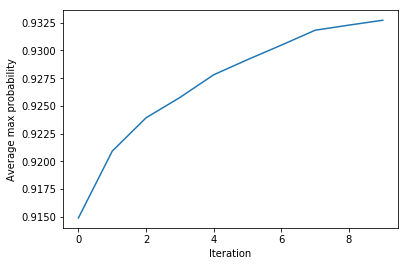

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(iter_probs_averages)
plt.ylabel('Average max probability')
plt.xlabel('Iteration')
plt.show()

In [96]:
inv_vocab = {v: k for k, v in vocabulary.items()}

# number of times word appears in topic k / number of words in topic k
number_of_words_in_topics = np.sum(word_topic_counts, 0)
phi = np.divide(word_topic_counts, number_of_words_in_topics)

# iterate through k topics and find words which have highest probability
for i in range(k):
    vocab_topic = np.argsort(-phi[:,i])[0:10]
    for vocab_idx in vocab_topic:
        print(inv_vocab[vocab_idx])
    print('')

people
edu
think
does
believe
writes
don
know
say
just

edu
image
graphics
com
use
file
files
like
images
bit

